In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import os
os.chdir('/content/drive/MyDrive/CS 282/')

In [ ]:
os.listdir()

['D_ITEMS.csv',
 'HW1',
 'HW3.ipynb',
 'HW2_code',
 'HW3 CS 282r.zip',
 'HW3_code_data.zip',
 'HW3',
 'D_ITEMS.csv.gz',
 'Checkpoint2',
 'Checkpoint-3',
 'lab-4-4-hileamlakB-master.zip',
 'lab-4-5-hileamlakB-master.zip',
 'Final']

In [ ]:
os.chdir('Final/Final project')

In [ ]:
import pandas as pd
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
import os, pickle
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder

from itertools import product

import sys, os

import trajectory as T                      # trajectory generation
import optimizer as O                       # stochastic gradient descent optimizer
import solver as S                          # MDP solver (value-iteration)
import plot as P


num_data = 355504


np.random.seed(66)

def to_interval(istr):
    c_left = istr[0]=='['
    c_right = istr[-1]==']'
    closed = {(True, False): 'left',
              (False, True): 'right',
              (True, True): 'both',
              (False, False): 'neither'
              }[c_left, c_right]
    # print(istr)
    # print(istr[1:-1].split(' - '))
    left, right = map(pd.to_datetime, istr[1:-1].split(' - '))
    # print(left, right)
    return pd.Interval(left, right, closed)

re_split = False
frac = [0.4,0.2,0.4]
assert np.sum(frac) == 1
frac = np.cumsum(frac)
print (frac)
data_save_path= 'data/'

def sliding(gs, window_size = 6):
    npr_l = []
    for g in gs:
        npr = np.concatenate([np.zeros([window_size-1, g.shape[1]]),g])
        npr_l.append(sliding_window_view(npr, (window_size, g.shape[1])).squeeze(1))
    return np.vstack(npr_l)

[0.4 0.6 1. ]


# LOADING THE DATA

In [ ]:
aggr_df = pd.read_csv('mimmic_ards_cut2.csv')
aggr_df

,stay_id,time,avg_respiratory_rate,avg_tidal_volume,avg_body_temperature,avg_peep,avg_fio2,avg_serum_creatinine,avg_blood_pressure,avg_heart_rate,avg_lactate,avg_glasgow_coma_scale_gcs,combined_actions,total_cost
0,200203,[2140-04-07 21:00:00 UTC - 2140-04-07 22:00:00...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,0.0
1,200203,[2140-04-07 18:00:00 UTC - 2140-04-07 19:00:00...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,0.0
2,200203,[2140-04-07 05:00:00 UTC - 2140-04-07 06:00:00...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,0.0
3,200203,[2140-04-07 19:00:00 UTC - 2140-04-07 20:00:00...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,0.0
4,200203,[2140-04-07 03:00:00 UTC - 2140-04-07 04:00:00...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62062,299828,[2179-03-31 21:00:00 UTC - 2179-03-31 22:00:00...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,0.0
62063,299828,[2179-03-31 15:00:00 UTC - 2179-03-31 16:00:00...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,0.0
62064,299828,[2179-03-31 20:00:00 UTC - 2179-03-31 21:00:00...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,0.0
62065,299828,[2179-03-31 17:00:00 UTC - 2179-03-31 18:00:00...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,0.0


In [ ]:
# if re_split:


aggr_df = pd.read_csv('mimmic_ards_cut2.csv',sep = ',', header = 0,converters={1:to_interval}).set_index(['stay_id','time']).sort_index()
aggr_df = aggr_df.rename(columns={
    'combined_actions': 'action',
    'total_cost': 'cost',
})
aggr_df.drop('cost', axis=1)
all_idx = np.random.permutation(aggr_df.index.get_level_values(0).unique())
train_df = aggr_df.loc[all_idx[:int(len(all_idx)*frac[0])]].sort_index()
test_df = aggr_df.loc[all_idx[int(len(all_idx)*frac[0]):int(len(all_idx)*frac[1])]].sort_index()
valid_df = aggr_df.loc[all_idx[int(len(all_idx)*frac[1]):]].sort_index()
drop_columns = ['cost']




In [ ]:
aggr_df['avg_peep'].mean()

6.380971128608924

# LOOKING AT THE DATA

In [ ]:
print(len(aggr_df))
specific_stay_id = 30001446
aggr_df.columns.tolist()
# len(aggr_df.loc[specific_stay_id])

62067


['avg_respiratory_rate',
 'avg_tidal_volume',
 'avg_body_temperature',
 'avg_peep',
 'avg_fio2',
 'avg_serum_creatinine',
 'avg_blood_pressure',
 'avg_heart_rate',
 'avg_lactate',
 'avg_glasgow_coma_scale_gcs',
 'action',
 'cost']

In [ ]:
train_df

avg_respiratory_rate  \
stay_id time                                                               
201404  [2158-01-15, 2158-01-15 01:00:00)                      21.166667   
        [2158-01-15 01:00:00, 2158-01-15 02:00:00)                   NaN   
        [2158-01-15 02:00:00, 2158-01-15 03:00:00)                   NaN   
        [2158-01-15 03:00:00, 2158-01-15 04:00:00)                   NaN   
        [2158-01-15 04:00:00, 2158-01-15 05:00:00)                   NaN   
...                                                                  ...   
299828  [2179-03-31 18:00:00, 2179-03-31 19:00:00)                   NaN   
        [2179-03-31 19:00:00, 2179-03-31 20:00:00)             15.000000   
        [2179-03-31 20:00:00, 2179-03-31 21:00:00)                   NaN   
        [2179-03-31 21:00:00, 2179-03-31 22:00:00)                   NaN   
        [2179-03-31 22:00:00, 2179-03-31 23:00:00)                   NaN   

                                                    avg_tidal_volume  \
stay_id time                                                           
201404  [2158-01-15, 2158-01-15 01:00:00)                        NaN   
        [2158-01-15 01:00:00, 2158-01-15 02:00:00)               NaN   
        [2158-01-15 02:00:00, 2158-01-15 03:00:00)               NaN   
        [2158-01-15 03:00:00, 2158-01-15 04:00:00)               NaN   
        [2158-01-15 04:00:00, 2158-01-15 05:00:00)               NaN   
...                                                              ...   
299828  [2179-03-31 18:00:00, 2179-03-31 19:00:00)               NaN   
        [2179-03-31 19:00:00, 2179-03-31 20:00:00)               NaN   
        [2179-03-31 20:00:00, 2179-03-31 21:00:00)               NaN   
        [2179-03-31 21:00:00, 2179-03-31 22:00:00)               NaN   
        [2179-03-31 22:00:00, 2179-03-31 23:00:00)               NaN   

                                                    avg_body_temperature  \
stay_id time                                                               
201404  [2158-01-15, 2158-01-15 01:00:00)                      97.300003   
        [2158-01-15 01:00:00, 2158-01-15 02:00:00)                   NaN   
        [2158-01-15 02:00:00, 2158-01-15 03:00:00)                   NaN   
        [2158-01-15 03:00:00, 2158-01-15 04:00:00)                   NaN   
        [2158-01-15 04:00:00, 2158-01-15 05:00:00)                   NaN   
...                                                                  ...   
299828  [2179-03-31 18:00:00, 2179-03-31 19:00:00)                   NaN   
        [2179-03-31 19:00:00, 2179-03-31 20:00:00)                   NaN   
        [2179-03-31 20:00:00, 2179-03-31 21:00:00)                   NaN   
        [2179-03-31 21:00:00, 2179-03-31 22:00:00)                   NaN   
        [2179-03-31 22:00:00, 2179-03-31 23:00:00)                   NaN   

                                                    avg_peep  avg_fio2  \
stay_id time                                                             
201404  [2158-01-15, 2158-01-15 01:00:00)                NaN       NaN   
        [2158-01-15 01:00:00, 2158-01-15 02:00:00)       NaN       NaN   
        [2158-01-15 02:00:00, 2158-01-15 03:00:00)       NaN       NaN   
        [2158-01-15 03:00:00, 2158-01-15 04:00:00)       NaN       NaN   
        [2158-01-15 04:00:00, 2158-01-15 05:00:00)       NaN       NaN   
...                                                      ...       ...   
299828  [2179-03-31 18:00:00, 2179-03-31 19:00:00)       NaN       NaN   
        [2179-03-31 19:00:00, 2179-03-31 20:00:00)       NaN       NaN   
        [2179-03-31 20:00:00, 2179-03-31 21:00:00)       NaN       NaN   
        [2179-03-31 21:00:00, 2179-03-31 22:00:00)       NaN       NaN   
        [2179-03-31 22:00:00, 2179-03-31 23:00:00)       NaN       NaN   

                                                    avg_serum_creatinine  \
stay_id time                                                               
201404  [2158-01-15, 2

In [ ]:
# for now drop indicators about bolus and vaso
# train_df = train_df.drop(columns=drop_columns)
# test_df = test_df.drop(columns=drop_columns)
# valid_df = valid_df.drop(columns=drop_columns)

#### imputation
impute_table = pd.read_csv('ards_impute_table.csv',sep=',',header=0).set_index(['feature'])
train_df = train_df.fillna(method='ffill')
test_df = test_df.fillna(method='ffill')
valid_df = valid_df.fillna(method='ffill')




for f in impute_table.index:
    f = f.strip()
    train_df[f] = train_df[f].fillna(value = impute_table.loc[f].values[0])
    test_df[f] = test_df[f].fillna(value = impute_table.loc[f].values[0])
    valid_df[f] = valid_df[f].fillna(value = impute_table.loc[f].values[0])


data_non_normalized_df = pd.concat([train_df, valid_df, test_df], axis=0, ignore_index=False).head(num_data).copy()

train_df.drop('avg_serum_creatinine', axis=1)
test_df.drop('avg_serum_creatinine', axis=1)
valid_df.drop('avg_serum_creatinine', axis= 1)

#### standard normalization ####
normalize_features = ['avg_respiratory_rate',
 'avg_tidal_volume',
 'avg_body_temperature',
 'avg_peep',
 'avg_fio2',
#  'avg_serum_creatinine',
 'avg_blood_pressure',
 'avg_heart_rate',
 'avg_lactate',
 'avg_glasgow_coma_scale_gcs',
 'cost'
 ]
mu, std = (train_df[normalize_features]).mean().values,(train_df[normalize_features]).std().values
train_df[normalize_features] = (train_df[normalize_features] - mu)/std
test_df[normalize_features] = (test_df[normalize_features] - mu)/std
valid_df[normalize_features] = (valid_df[normalize_features] - mu)/std




### create data matrix ####
X_train = train_df.loc[:,train_df.columns!='action']
y_train = train_df['action']

X_test = test_df.loc[:,test_df.columns!='action']
y_test = test_df['action']

X_valid = valid_df.loc[:, valid_df.columns!='action']
y_valid = valid_df['action']
train_df

avg_respiratory_rate  \
stay_id time                                                               
201039  [2145-03-31, 2145-03-31 01:00:00)                      -0.243508   
        [2145-03-31 01:00:00, 2145-03-31 02:00:00)              0.728876   
        [2145-03-31 02:00:00, 2145-03-31 03:00:00)              0.728876   
        [2145-03-31 03:00:00, 2145-03-31 04:00:00)              0.728876   
        [2145-03-31 04:00:00, 2145-03-31 05:00:00)              0.728876   
...                                                                  ...   
299794  [2129-04-17 19:00:00, 2129-04-17 20:00:00)             -0.081444   
        [2129-04-17 20:00:00, 2129-04-17 21:00:00)             -0.081444   
        [2129-04-17 21:00:00, 2129-04-17 22:00:00)             -0.081444   
        [2129-04-17 22:00:00, 2129-04-17 23:00:00)             -0.081444   
        [2129-04-17 23:00:00, 2129-04-18)                      -0.081444   

                                                    avg_tidal_volume  \
stay_id time                                                           
201039  [2145-03-31, 2145-03-31 01:00:00)                  -0.014007   
        [2145-03-31 01:00:00, 2145-03-31 02:00:00)         -0.014007   
        [2145-03-31 02:00:00, 2145-03-31 03:00:00)         -0.014007   
        [2145-03-31 03:00:00, 2145-03-31 04:00:00)         -0.014007   
        [2145-03-31 04:00:00, 2145-03-31 05:00:00)         -0.014007   
...                                                              ...   
299794  [2129-04-17 19:00:00, 2129-04-17 20:00:00)         -0.370171   
        [2129-04-17 20:00:00, 2129-04-17 21:00:00)         -0.370171   
        [2129-04-17 21:00:00, 2129-04-17 22:00:00)         -0.370171   
        [2129-04-17 22:00:00, 2129-04-17 23:00:00)         -0.370171   
        [2129-04-17 23:00:00, 2129-04-18)                  -0.370171   

                                                    avg_body_temperature  \
stay_id time                                                               
201039  [2145-03-31, 2145-03-31 01:00:00)                      -7.081162   
        [2145-03-31 01:00:00, 2145-03-31 02:00:00)             -7.081162   
        [2145-03-31 02:00:00, 2145-03-31 03:00:00)             -7.081162   
        [2145-03-31 03:00:00, 2145-03-31 04:00:00)             -7.081162   
        [2145-03-31 04:00:00, 2145-03-31 05:00:00)             -7.081162   
...                                                                  ...   
299794  [2129-04-17 19:00:00, 2129-04-17 20:00:00)             -0.102764   
        [2129-04-17 20:00:00, 2129-04-17 21:00:00)             -0.102764   
        [2129-04-17 21:00:00, 2129-04-17 22:00:00)             -0.102764   
        [2129-04-17 22:00:00, 2129-04-17 23:00:00)             -0.102764   
        [2129-04-17 23:00:00, 2129-04-18)                      -0.102764   

                                                    avg_peep  avg_fio2  \
stay_id time                                                             
201039  [2145-03-31, 2145-03-31 01:00:00)          -0.448852    0.1487   
        [2145-03-31 01:00:00, 2145-03-31 02:00:00) -0.448852    0.1487   
        [2145-03-31 02:00:00, 2145-03-31 03:00:00) -0.448852    0.1487   
        [2145-03-31 03:00:00, 2145-03-31 04:00:00) -0.448852    0.1487   
        [2145-03-31 04:00:00, 2145-03-31 05:00:00) -0.448852    0.1487   
...                                                      ...       ...   
299794  [2129-04-17 19:00:00, 2129-04-17 20:00:00)  1.301929    0.1487   
        [2129-04-17 20:00:00, 2129-04-17 21:00:00)  1.301929    0.1487   
        [2129-04-17 21:00:00, 2129-04-17 22:00:00)  1.301929    0.1487   
        [2129-04-17 22:00:00, 2129-04-17 23:00:00)  1.301929    0.1487   
        [2129-04-17 23:00:00, 2129-04-18)           1.301929    0.1487   

                                                    avg_serum_creatinine  \
stay_id time                                                               
201039  [2145-03-31, 2

In [ ]:
type(impute_table.loc['avg_serum_creatinine'].values[0]), train_df['avg_serum_creatinine']

train_df


avg_respiratory_rate  \
stay_id time                                                               
201039  [2145-03-31, 2145-03-31 01:00:00)                      -0.243508   
        [2145-03-31 01:00:00, 2145-03-31 02:00:00)              0.728876   
        [2145-03-31 02:00:00, 2145-03-31 03:00:00)              0.728876   
        [2145-03-31 03:00:00, 2145-03-31 04:00:00)              0.728876   
        [2145-03-31 04:00:00, 2145-03-31 05:00:00)              0.728876   
...                                                                  ...   
299794  [2129-04-17 19:00:00, 2129-04-17 20:00:00)             -0.081444   
        [2129-04-17 20:00:00, 2129-04-17 21:00:00)             -0.081444   
        [2129-04-17 21:00:00, 2129-04-17 22:00:00)             -0.081444   
        [2129-04-17 22:00:00, 2129-04-17 23:00:00)             -0.081444   
        [2129-04-17 23:00:00, 2129-04-18)                      -0.081444   

                                                    avg_tidal_volume  \
stay_id time                                                           
201039  [2145-03-31, 2145-03-31 01:00:00)                  -0.014007   
        [2145-03-31 01:00:00, 2145-03-31 02:00:00)         -0.014007   
        [2145-03-31 02:00:00, 2145-03-31 03:00:00)         -0.014007   
        [2145-03-31 03:00:00, 2145-03-31 04:00:00)         -0.014007   
        [2145-03-31 04:00:00, 2145-03-31 05:00:00)         -0.014007   
...                                                              ...   
299794  [2129-04-17 19:00:00, 2129-04-17 20:00:00)         -0.370171   
        [2129-04-17 20:00:00, 2129-04-17 21:00:00)         -0.370171   
        [2129-04-17 21:00:00, 2129-04-17 22:00:00)         -0.370171   
        [2129-04-17 22:00:00, 2129-04-17 23:00:00)         -0.370171   
        [2129-04-17 23:00:00, 2129-04-18)                  -0.370171   

                                                    avg_body_temperature  \
stay_id time                                                               
201039  [2145-03-31, 2145-03-31 01:00:00)                      -7.081162   
        [2145-03-31 01:00:00, 2145-03-31 02:00:00)             -7.081162   
        [2145-03-31 02:00:00, 2145-03-31 03:00:00)             -7.081162   
        [2145-03-31 03:00:00, 2145-03-31 04:00:00)             -7.081162   
        [2145-03-31 04:00:00, 2145-03-31 05:00:00)             -7.081162   
...                                                                  ...   
299794  [2129-04-17 19:00:00, 2129-04-17 20:00:00)             -0.102764   
        [2129-04-17 20:00:00, 2129-04-17 21:00:00)             -0.102764   
        [2129-04-17 21:00:00, 2129-04-17 22:00:00)             -0.102764   
        [2129-04-17 22:00:00, 2129-04-17 23:00:00)             -0.102764   
        [2129-04-17 23:00:00, 2129-04-18)                      -0.102764   

                                                    avg_peep  avg_fio2  \
stay_id time                                                             
201039  [2145-03-31, 2145-03-31 01:00:00)          -0.448852    0.1487   
        [2145-03-31 01:00:00, 2145-03-31 02:00:00) -0.448852    0.1487   
        [2145-03-31 02:00:00, 2145-03-31 03:00:00) -0.448852    0.1487   
        [2145-03-31 03:00:00, 2145-03-31 04:00:00) -0.448852    0.1487   
        [2145-03-31 04:00:00, 2145-03-31 05:00:00) -0.448852    0.1487   
...                                                      ...       ...   
299794  [2129-04-17 19:00:00, 2129-04-17 20:00:00)  1.301929    0.1487   
        [2129-04-17 20:00:00, 2129-04-17 21:00:00)  1.301929    0.1487   
        [2129-04-17 21:00:00, 2129-04-17 22:00:00)  1.301929    0.1487   
        [2129-04-17 22:00:00, 2129-04-17 23:00:00)  1.301929    0.1487   
        [2129-04-17 23:00:00, 2129-04-18)           1.301929    0.1487   

                                                    avg_serum_creatinine  \
stay_id time                                                               
201039  [2145-03-31, 2

In [ ]:
X_df = pd.concat([X_train, X_valid, X_test], axis=0, ignore_index=True).copy()
y_df = pd.concat([y_train, y_valid, y_test], axis=0, ignore_index=True).copy()


In [ ]:
data_df = pd.concat([train_df, valid_df, test_df], axis=0, ignore_index=False).copy()
# data_df = data_df.head(num_data).copy()
# X_df = X_df.head(num_data).copy()
# y_df = y_df.head(num_data).copy()


In [ ]:
print(len(data_df))
print(len(X_df))
print(len(y_df))
print(len(data_non_normalized_df))

62067
62067
62067
62067


# Normalized version of the data

In [ ]:
data_df.head()

avg_respiratory_rate  \
stay_id time                                                               
201039  [2145-03-31, 2145-03-31 01:00:00)                      -0.243508   
        [2145-03-31 01:00:00, 2145-03-31 02:00:00)              0.728876   
        [2145-03-31 02:00:00, 2145-03-31 03:00:00)              0.728876   
        [2145-03-31 03:00:00, 2145-03-31 04:00:00)              0.728876   
        [2145-03-31 04:00:00, 2145-03-31 05:00:00)              0.728876   

                                                    avg_tidal_volume  \
stay_id time                                                           
201039  [2145-03-31, 2145-03-31 01:00:00)                  -0.014007   
        [2145-03-31 01:00:00, 2145-03-31 02:00:00)         -0.014007   
        [2145-03-31 02:00:00, 2145-03-31 03:00:00)         -0.014007   
        [2145-03-31 03:00:00, 2145-03-31 04:00:00)         -0.014007   
        [2145-03-31 04:00:00, 2145-03-31 05:00:00)         -0.014007   

                                                    avg_body_temperature  \
stay_id time                                                               
201039  [2145-03-31, 2145-03-31 01:00:00)                      -7.081162   
        [2145-03-31 01:00:00, 2145-03-31 02:00:00)             -7.081162   
        [2145-03-31 02:00:00, 2145-03-31 03:00:00)             -7.081162   
        [2145-03-31 03:00:00, 2145-03-31 04:00:00)             -7.081162   
        [2145-03-31 04:00:00, 2145-03-31 05:00:00)             -7.081162   

                                                    avg_peep  avg_fio2  \
stay_id time                                                             
201039  [2145-03-31, 2145-03-31 01:00:00)          -0.448852    0.1487   
        [2145-03-31 01:00:00, 2145-03-31 02:00:00) -0.448852    0.1487   
        [2145-03-31 02:00:00, 2145-03-31 03:00:00) -0.448852    0.1487   
        [2145-03-31 03:00:00, 2145-03-31 04:00:00) -0.448852    0.1487   
        [2145-03-31 04:00:00, 2145-03-31 05:00:00) -0.448852    0.1487   

                                                    avg_serum_creatinine  \
stay_id time                                                               
201039  [2145-03-31, 2145-03-31 01:00:00)                            1.0   
        [2145-03-31 01:00:00, 2145-03-31 02:00:00)                   1.0   
        [2145-03-31 02:00:00, 2145-03-31 03:00:00)                   1.0   
        [2145-03-31 03:00:00, 2145-03-31 04:00:00)                   1.0   
        [2145-03-31 04:00:00, 2145-03-31 05:00:00)                   1.0   

                                                    avg_blood_pressure  \
stay_id time                                                             
201039  [2145-03-31, 2145-03-31 01:00:00)                    -1.840682   
        [2145-03-31 01:00:00, 2145-03-31 02:00:00)           -0.950671   
        [2145-03-31 02:00:00, 2145-03-31 03:00:00)           -0.950671   
        [2145-03-31 03:00:00, 2145-03-31 04:00:00)           -0.950671   
        [2145-03-31 04:00:00, 2145-03-31 05:00:00)           -0.950671   

                                                    avg_heart_rate  \
stay_id time                                                         
201039  [2145-03-31, 2145-03-31 01:00:00)                -0.156347   
        [2145-03-31 01:00:00, 2145-03-31 02:00:00)        0.633758   
        [2145-03-31 02:00:00, 2145-03-31 03:00:00)        0.633758   
        [2145-03-31 03:00:00, 2145-03-31 04:00:00)        0.633758   
        [2145-03-31 04:00:00, 2145-03-31 05:00:00)        0.633758   

                                                    avg_lactate  \
stay_id time                                                      
201039  [2145-03-31, 2145-03-31 01:00:00)              -0.99998   
        [2145-03-31 01:00:00, 2145-03-31 02:00:00)     -0.99998   
        [2145-03-31 02:00:00, 2145-03-31 03:00:00)     -0.99998   
        [2145-03-31 03:00:00, 2145-03-31 04:00:00)     -0.99998   
        [2145-03-

# Unormalized version of the data

In [ ]:
data_non_normalized_df.head()

avg_respiratory_rate  \
stay_id time                                                               
201039  [2145-03-31, 2145-03-31 01:00:00)                      -0.243508   
        [2145-03-31 01:00:00, 2145-03-31 02:00:00)              0.728876   
        [2145-03-31 02:00:00, 2145-03-31 03:00:00)              0.728876   
        [2145-03-31 03:00:00, 2145-03-31 04:00:00)              0.728876   
        [2145-03-31 04:00:00, 2145-03-31 05:00:00)              0.728876   

                                                    avg_tidal_volume  \
stay_id time                                                           
201039  [2145-03-31, 2145-03-31 01:00:00)                  -0.014007   
        [2145-03-31 01:00:00, 2145-03-31 02:00:00)         -0.014007   
        [2145-03-31 02:00:00, 2145-03-31 03:00:00)         -0.014007   
        [2145-03-31 03:00:00, 2145-03-31 04:00:00)         -0.014007   
        [2145-03-31 04:00:00, 2145-03-31 05:00:00)         -0.014007   

                                                    avg_body_temperature  \
stay_id time                                                               
201039  [2145-03-31, 2145-03-31 01:00:00)                      -7.081162   
        [2145-03-31 01:00:00, 2145-03-31 02:00:00)             -7.081162   
        [2145-03-31 02:00:00, 2145-03-31 03:00:00)             -7.081162   
        [2145-03-31 03:00:00, 2145-03-31 04:00:00)             -7.081162   
        [2145-03-31 04:00:00, 2145-03-31 05:00:00)             -7.081162   

                                                    avg_peep  avg_fio2  \
stay_id time                                                             
201039  [2145-03-31, 2145-03-31 01:00:00)          -0.448852    0.1487   
        [2145-03-31 01:00:00, 2145-03-31 02:00:00) -0.448852    0.1487   
        [2145-03-31 02:00:00, 2145-03-31 03:00:00) -0.448852    0.1487   
        [2145-03-31 03:00:00, 2145-03-31 04:00:00) -0.448852    0.1487   
        [2145-03-31 04:00:00, 2145-03-31 05:00:00) -0.448852    0.1487   

                                                    avg_serum_creatinine  \
stay_id time                                                               
201039  [2145-03-31, 2145-03-31 01:00:00)                            1.0   
        [2145-03-31 01:00:00, 2145-03-31 02:00:00)                   1.0   
        [2145-03-31 02:00:00, 2145-03-31 03:00:00)                   1.0   
        [2145-03-31 03:00:00, 2145-03-31 04:00:00)                   1.0   
        [2145-03-31 04:00:00, 2145-03-31 05:00:00)                   1.0   

                                                    avg_blood_pressure  \
stay_id time                                                             
201039  [2145-03-31, 2145-03-31 01:00:00)                    -1.840682   
        [2145-03-31 01:00:00, 2145-03-31 02:00:00)           -0.950671   
        [2145-03-31 02:00:00, 2145-03-31 03:00:00)           -0.950671   
        [2145-03-31 03:00:00, 2145-03-31 04:00:00)           -0.950671   
        [2145-03-31 04:00:00, 2145-03-31 05:00:00)           -0.950671   

                                                    avg_heart_rate  \
stay_id time                                                         
201039  [2145-03-31, 2145-03-31 01:00:00)                -0.156347   
        [2145-03-31 01:00:00, 2145-03-31 02:00:00)        0.633758   
        [2145-03-31 02:00:00, 2145-03-31 03:00:00)        0.633758   
        [2145-03-31 03:00:00, 2145-03-31 04:00:00)        0.633758   
        [2145-03-31 04:00:00, 2145-03-31 05:00:00)        0.633758   

                                                    avg_lactate  \
stay_id time                                                      
201039  [2145-03-31, 2145-03-31 01:00:00)              -0.99998   
        [2145-03-31 01:00:00, 2145-03-31 02:00:00)     -0.99998   
        [2145-03-31 02:00:00, 2145-03-31 03:00:00)     -0.99998   
        [2145-03-31 03:00:00, 2145-03-31 04:00:00)     -0.99998   
        [2145-03-

# Matrix form of the data (Normalized and features only)

In [ ]:
X_df

,avg_respiratory_rate,avg_tidal_volume,avg_body_temperature,avg_peep,avg_fio2,avg_serum_creatinine,avg_blood_pressure,avg_heart_rate,avg_lactate,avg_glasgow_coma_scale_gcs,cost
0,-0.243508,-0.014007,-7.081162,-0.448852,0.148700,1.0,-1.840682,-0.156347,-0.99998,0.661055,18993.333333
1,0.728876,-0.014007,-7.081162,-0.448852,0.148700,1.0,-0.950671,0.633758,-0.99998,0.661055,140110.666667
2,0.728876,-0.014007,-7.081162,-0.448852,0.148700,1.0,-0.950671,0.633758,-0.99998,0.661055,0.000000
3,0.728876,-0.014007,-7.081162,-0.448852,0.148700,1.0,-0.950671,0.633758,-0.99998,0.661055,0.000000
4,0.728876,-0.014007,-7.081162,-0.448852,0.148700,1.0,-0.950671,0.633758,-0.99998,0.661055,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
62062,0.080620,0.579601,0.144781,-0.448852,-0.196473,1.0,1.237271,-0.103673,-0.99998,0.167667,12.032400
62063,0.080620,0.579601,0.144781,-0.448852,-0.196473,1.0,1.237271,-0.103673,-0.99998,0.167667,0.000000
62064,0.080620,0.579601,0.144781,-0.448852,-0.196473,1.0,1.237271,-0.103673,-0.99998,0.167667,0.000000
62065,0.080620,0.579601,0.144781,-0.448852,-0.196473,1.0,1.237271,-0.103673,-0.99998,0.167667,0.000000


# Corresponding output data for training BC (corresponding treatments for each data point in X_df)

In [ ]:
y_df

0        4.0
1        4.0
2        4.0
3        4.0
4        4.0
        ... 
62062    3.0
62063    4.0
62064    4.0
62065    4.0
62066    4.0
Name: action, Length: 62067, dtype: float64

# Clustering the feature space to extract a discrete state space form the clusters

In [ ]:
X_df

,avg_respiratory_rate,avg_tidal_volume,avg_body_temperature,avg_peep,avg_fio2,avg_serum_creatinine,avg_blood_pressure,avg_heart_rate,avg_lactate,avg_glasgow_coma_scale_gcs,cost
0,-0.243508,-0.014007,-7.081162,-0.448852,0.148700,1.0,-1.840682,-0.156347,-0.99998,0.661055,18993.333333
1,0.728876,-0.014007,-7.081162,-0.448852,0.148700,1.0,-0.950671,0.633758,-0.99998,0.661055,140110.666667
2,0.728876,-0.014007,-7.081162,-0.448852,0.148700,1.0,-0.950671,0.633758,-0.99998,0.661055,0.000000
3,0.728876,-0.014007,-7.081162,-0.448852,0.148700,1.0,-0.950671,0.633758,-0.99998,0.661055,0.000000
4,0.728876,-0.014007,-7.081162,-0.448852,0.148700,1.0,-0.950671,0.633758,-0.99998,0.661055,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
62062,0.080620,0.579601,0.144781,-0.448852,-0.196473,1.0,1.237271,-0.103673,-0.99998,0.167667,12.032400
62063,0.080620,0.579601,0.144781,-0.448852,-0.196473,1.0,1.237271,-0.103673,-0.99998,0.167667,0.000000
62064,0.080620,0.579601,0.144781,-0.448852,-0.196473,1.0,1.237271,-0.103673,-0.99998,0.167667,0.000000
62065,0.080620,0.579601,0.144781,-0.448852,-0.196473,1.0,1.237271,-0.103673,-0.99998,0.167667,0.000000


In [ ]:


# Assuming df is your DataFrame
# df = pd.DataFrame(...)

# Step 1: Identify NaN values
nan_mask = X_df.isna()

# Step 2: Get the index and column of NaN values
nan_locations = nan_mask.stack()[lambda x: x].index.tolist()

nan_cost_rows = train_df[train_df['cost'].isna()]

# Display the 'action' column for these rows
print(nan_cost_rows[['cost', 'action']])


Empty DataFrame
Columns: [cost, action]
Index: []


In [ ]:
# num_clusters = 25

from sklearn.cluster import DBSCAN

# Define DBSCAN parameters
eps = 0.5  # example value, adjust based on your data
min_samples = 5  # example value, adjust based on your data

# Create DBSCAN instance
dbscan = DBSCAN(eps=eps, min_samples=100)

# Fit DBSCAN to your data
dbscan.fit(X_df)

# kmeans = KMeans(n_clusters= num_clusters , random_state=0)
# kmeans.fit(X_df)


DBSCAN(min_samples=100)

In [ ]:
# Looking at the values counts for each cluster
counts = np.unique(dbscan.labels_, return_counts = True)[1]
counts

array([56969,  2234,   259,   378,   100,    68,   129,   178,   101,
         335,   121,   135,   102,   104,   119,    18,   130,   101,
          93,   101,   102,   111,    79])

In [ ]:
len(dbscan.labels_)

62067

In [ ]:
# Assigning each data point to a cluster
X_df['cluster'] = dbscan.labels_.copy()
data_df['cluster'] = dbscan.labels_.copy()
data_non_normalized_df['cluster'] = dbscan.labels_.copy()

In [ ]:
data_df.head()

avg_respiratory_rate  \
stay_id time                                                               
201404  [2158-01-15, 2158-01-15 01:00:00)                       0.061283   
        [2158-01-15 01:00:00, 2158-01-15 02:00:00)              0.061283   
        [2158-01-15 02:00:00, 2158-01-15 03:00:00)              0.061283   
        [2158-01-15 03:00:00, 2158-01-15 04:00:00)              0.061283   
        [2158-01-15 04:00:00, 2158-01-15 05:00:00)              0.061283   

                                                    avg_tidal_volume  \
stay_id time                                                           
201404  [2158-01-15, 2158-01-15 01:00:00)                  -0.045461   
        [2158-01-15 01:00:00, 2158-01-15 02:00:00)         -0.045461   
        [2158-01-15 02:00:00, 2158-01-15 03:00:00)         -0.045461   
        [2158-01-15 03:00:00, 2158-01-15 04:00:00)         -0.045461   
        [2158-01-15 04:00:00, 2158-01-15 05:00:00)         -0.045461   

                                                    avg_body_temperature  \
stay_id time                                                               
201404  [2158-01-15, 2158-01-15 01:00:00)                      -0.001291   
        [2158-01-15 01:00:00, 2158-01-15 02:00:00)             -0.001291   
        [2158-01-15 02:00:00, 2158-01-15 03:00:00)             -0.001291   
        [2158-01-15 03:00:00, 2158-01-15 04:00:00)             -0.001291   
        [2158-01-15 04:00:00, 2158-01-15 05:00:00)             -0.001291   

                                                    avg_peep  avg_fio2  \
stay_id time                                                             
201404  [2158-01-15, 2158-01-15 01:00:00)           -0.32516 -0.012009   
        [2158-01-15 01:00:00, 2158-01-15 02:00:00)  -0.32516 -0.012009   
        [2158-01-15 02:00:00, 2158-01-15 03:00:00)  -0.32516 -0.012009   
        [2158-01-15 03:00:00, 2158-01-15 04:00:00)  -0.32516 -0.012009   
        [2158-01-15 04:00:00, 2158-01-15 05:00:00)  -0.32516 -0.012009   

                                                    avg_serum_creatinine  \
stay_id time                                                               
201404  [2158-01-15, 2158-01-15 01:00:00)                            1.0   
        [2158-01-15 01:00:00, 2158-01-15 02:00:00)                   1.0   
        [2158-01-15 02:00:00, 2158-01-15 03:00:00)                   1.0   
        [2158-01-15 03:00:00, 2158-01-15 04:00:00)                   1.0   
        [2158-01-15 04:00:00, 2158-01-15 05:00:00)                   1.0   

                                                    avg_blood_pressure  \
stay_id time                                                             
201404  [2158-01-15, 2158-01-15 01:00:00)                    -1.922815   
        [2158-01-15 01:00:00, 2158-01-15 02:00:00)           -1.922815   
        [2158-01-15 02:00:00, 2158-01-15 03:00:00)           -1.922815   
        [2158-01-15 03:00:00, 2158-01-15 04:00:00)           -1.922815   
        [2158-01-15 04:00:00, 2158-01-15 05:00:00)           -1.922815   

                                                    avg_heart_rate  \
stay_id time                                                         
201404  [2158-01-15, 2158-01-15 01:00:00)                -0.862445   
        [2158-01-15 01:00:00, 2158-01-15 02:00:00)       -0.862445   
        [2158-01-15 02:00:00, 2158-01-15 03:00:00)       -0.862445   
        [2158-01-15 03:00:00, 2158-01-15 04:00:00)       -0.862445   
        [2158-01-15 04:00:00, 2158-01-15 05:00:00)       -0.862445   

                                                    avg_lactate  \
stay_id time                                                      
201404  [2158-01-15, 2158-01-15 01:00:00)             -0.999981   
        [2158-01-15 01:00:00, 2158-01-15 02:00:00)    -0.999981   
        [2158-01-15 02:00:00, 2158-01-15 03:00:00)    -0.999981   
        [2158-01-15 03:00:00, 2158-01-15 04:00:00)    -0.999981   
        [2158-01-

In [ ]:
X_df.head()

,avg_respiratory_rate,avg_tidal_volume,avg_body_temperature,avg_peep,avg_fio2,avg_serum_creatinine,avg_blood_pressure,avg_heart_rate,avg_lactate,avg_glasgow_coma_scale_gcs,cluster
0,0.061283,-0.045461,-0.001291,-0.32516,-0.012009,1.0,-1.922815,-0.862445,-0.999981,0.71089,23
1,0.061283,-0.045461,-0.001291,-0.32516,-0.012009,1.0,-1.922815,-0.862445,-0.999981,0.71089,23
2,0.061283,-0.045461,-0.001291,-0.32516,-0.012009,1.0,-1.922815,-0.862445,-0.999981,0.71089,23
3,0.061283,-0.045461,-0.001291,-0.32516,-0.012009,1.0,-1.922815,-0.862445,-0.999981,0.71089,23
4,0.061283,-0.045461,-0.001291,-0.32516,-0.012009,1.0,-1.922815,-0.862445,-0.999981,0.71089,23


In [ ]:
data_non_normalized_df.head()

avg_respiratory_rate  \
stay_id time                                                               
201404  [2158-01-15, 2158-01-15 01:00:00)                      21.166667   
        [2158-01-15 01:00:00, 2158-01-15 02:00:00)             21.166667   
        [2158-01-15 02:00:00, 2158-01-15 03:00:00)             21.166667   
        [2158-01-15 03:00:00, 2158-01-15 04:00:00)             21.166667   
        [2158-01-15 04:00:00, 2158-01-15 05:00:00)             21.166667   

                                                    avg_tidal_volume  \
stay_id time                                                           
201404  [2158-01-15, 2158-01-15 01:00:00)                      500.0   
        [2158-01-15 01:00:00, 2158-01-15 02:00:00)             500.0   
        [2158-01-15 02:00:00, 2158-01-15 03:00:00)             500.0   
        [2158-01-15 03:00:00, 2158-01-15 04:00:00)             500.0   
        [2158-01-15 04:00:00, 2158-01-15 05:00:00)             500.0   

                                                    avg_body_temperature  \
stay_id time                                                               
201404  [2158-01-15, 2158-01-15 01:00:00)                      97.300003   
        [2158-01-15 01:00:00, 2158-01-15 02:00:00)             97.300003   
        [2158-01-15 02:00:00, 2158-01-15 03:00:00)             97.300003   
        [2158-01-15 03:00:00, 2158-01-15 04:00:00)             97.300003   
        [2158-01-15 04:00:00, 2158-01-15 05:00:00)             97.300003   

                                                    avg_peep  avg_fio2  \
stay_id time                                                             
201404  [2158-01-15, 2158-01-15 01:00:00)                5.0       0.6   
        [2158-01-15 01:00:00, 2158-01-15 02:00:00)       5.0       0.6   
        [2158-01-15 02:00:00, 2158-01-15 03:00:00)       5.0       0.6   
        [2158-01-15 03:00:00, 2158-01-15 04:00:00)       5.0       0.6   
        [2158-01-15 04:00:00, 2158-01-15 05:00:00)       5.0       0.6   

                                                    avg_serum_creatinine  \
stay_id time                                                               
201404  [2158-01-15, 2158-01-15 01:00:00)                            1.0   
        [2158-01-15 01:00:00, 2158-01-15 02:00:00)                   1.0   
        [2158-01-15 02:00:00, 2158-01-15 03:00:00)                   1.0   
        [2158-01-15 03:00:00, 2158-01-15 04:00:00)                   1.0   
        [2158-01-15 04:00:00, 2158-01-15 05:00:00)                   1.0   

                                                    avg_blood_pressure  \
stay_id time                                                             
201404  [2158-01-15, 2158-01-15 01:00:00)                         77.0   
        [2158-01-15 01:00:00, 2158-01-15 02:00:00)                77.0   
        [2158-01-15 02:00:00, 2158-01-15 03:00:00)                77.0   
        [2158-01-15 03:00:00, 2158-01-15 04:00:00)                77.0   
        [2158-01-15 04:00:00, 2158-01-15 05:00:00)                77.0   

                                                    avg_heart_rate  \
stay_id time                                                         
201404  [2158-01-15, 2158-01-15 01:00:00)                70.416667   
        [2158-01-15 01:00:00, 2158-01-15 02:00:00)       70.416667   
        [2158-01-15 02:00:00, 2158-01-15 03:00:00)       70.416667   
        [2158-01-15 03:00:00, 2158-01-15 04:00:00)       70.416667   
        [2158-01-15 04:00:00, 2158-01-15 05:00:00)       70.416667   

                                                    avg_lactate  \
stay_id time                                                      
201404  [2158-01-15, 2158-01-15 01:00:00)                   1.8   
        [2158-01-15 01:00:00, 2158-01-15 02:00:00)          1.8   
        [2158-01-15 02:00:00, 2158-01-15 03:00:00)          1.8   
        [2158-01-15 03:00:00, 2158-01-15 04:00:00)          1.8   
        [2158-01-

In [ ]:
unique_stay_ids = data_df.index.get_level_values('stay_id').unique()

trajectories = []


for stay_id in unique_stay_ids:


  states, actions = data_df.loc[stay_id]['cluster'], data_df.loc[stay_id]['action']

  trajectory = []
  for i in range(len(states) - 1):
    trajectory.append((states[i], int(actions[i]), states[i+1] ))

  if trajectory:
    trajectories.append(T.Trajectory(trajectory))

In [ ]:
len(states)

13

We need to store all possible terminal states from the trajectories list. (Needed to calculate the normalizing constant in MaxEnt)

In [ ]:
terminal_states = []

for traj in trajectories:
  terminal_states.append(traj._t[-1][-1])

terminal_states = list(set(terminal_states))

In [ ]:
terminal_states

[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, -1]

# Distribution of the treatments given in our data. (Most of the time no treatment is given, might vary on depending on how you cluster the data)

In [ ]:
y_df.value_counts()

4.0    57893
2.0     1977
0.0      914
3.0      889
1.0      394
Name: action, dtype: int64

# Estimating the Transition Dynamics using the MLE (feel free to play around with the smoothing_value)

In [ ]:
smoothing_value = 1

p_transition = np.zeros((23, 23, 5)) + smoothing_value


for traj in trajectories:

    for tran in traj._t:

      p_transition[tran[0], tran[2], tran[1]] +=1

p_transition = p_transition/ p_transition.sum(axis = 1)[:, np.newaxis, :]

In [ ]:
p_transition

array([[[4.34782609e-02, 8.33333333e-02, 1.78571429e-01, 1.20000000e-01,
         8.91205802e-01],
        [4.34782609e-02, 4.16666667e-02, 3.57142857e-02, 4.00000000e-02,
         4.53309157e-04],
        [4.34782609e-02, 4.16666667e-02, 3.57142857e-02, 4.00000000e-02,
         4.53309157e-04],
        ...,
        [4.34782609e-02, 4.16666667e-02, 3.57142857e-02, 4.00000000e-02,
         4.53309157e-04],
        [4.34782609e-02, 4.16666667e-02, 3.57142857e-02, 4.00000000e-02,
         9.06618314e-04],
        [4.34782609e-02, 4.16666667e-02, 7.14285714e-02, 4.00000000e-02,
         9.74614687e-02]],

       [[4.34782609e-02, 4.34782609e-02, 4.34782609e-02, 4.34782609e-02,
         3.54609929e-03],
        [4.34782609e-02, 4.34782609e-02, 4.34782609e-02, 4.34782609e-02,
         8.51063830e-01],
        [4.34782609e-02, 4.34782609e-02, 4.34782609e-02, 4.34782609e-02,
         3.54609929e-03],
        ...,
        [4.34782609e-02, 4.34782609e-02, 4.34782609e-02, 4.34782609e-02,
        

# Max Causal Entropy

In [ ]:
discount = 0.9

In [ ]:
from maxent import irl, irl_causal

In [ ]:
# set up features: we use one feature vector per state (1 hot encoding for each cluster/state)
features = state_encoder.transform(np.arange(-1, 22).reshape(-1, 1))

# choose our parameter initialization strategy:
#   initialize parameters with constant
init = O.Constant(1.0)

# choose our optimization strategy:
#   we select exponentiated stochastic gradient descent with linear learning-rate decay
optim = O.ExpSga(lr=O.linear_decay(lr0=0.001))

# actually do some inverse reinforcement learning
#reward_maxent = irl(p_transition, features, terminal_states, trajectories, optim, init, eps= 1e-3)

reward_maxent_causal = irl_causal(p_transition, features, terminal_states, trajectories, optim, init, discount,
               eps=1e-3, eps_svf=1e-4, eps_lap=1e-4)

inf
0.043725344662431276
0.022574495862544897
0.01532027143435033
0.011634483161993447
0.009397627747134374
0.007893035608317778
0.006810413296001405
0.005993363101213012
0.0053544166946812854
0.00484079261560888
0.004418734164040261
0.0040656362950919345
0.003765786251906489
0.003507919382097935
0.0032837470346924746
0.0030870332891728136
0.0029129956267961443
0.0027579041884366884
0.0026188068211350224
0.0024933361097758677
0.0023795712049914375
0.002275937101904768
0.0021811300307994497
0.002094061383565826
0.002013815013228948
0.0019396143251861897
0.0018707966350883787
0.0018067929864313825
0.0017471121170897774
0.0016913276119387977
0.0016390675260335996
0.001590005940852457
0.0015438560458069794
0.0015003644327151733
0.0014593063619821045
0.0014204818125878038
0.0013837121684170395
0.0013488374243575407
0.0013157138194022089
0.0012842118224383192
0.001254214410850052
0.001225615593406948
0.0011983191378894809
0.0011722374710705363
0.0011472907243847974
0.0011234059032483312
0.00

In [ ]:
reward_maxent_causal

array([1.00773578, 1.00089442, 1.00131109, 1.00034482, 1.00023325,
       1.00043896, 1.00060635, 1.00034831, 1.00115405, 1.00041804,
       1.0004564 , 1.00035179, 1.00035877, 1.00040758, 1.00005896,
       1.00044942, 1.00034831, 1.0003239 , 1.00035179, 1.00035528,
       1.00038666, 1.00026812, 1.21435349])

# Computing the policy induced by your learnt reward

In [ ]:
V, Q = S.value_iteration(p_transition, reward_maxent_causal, discount)

In [ ]:
Q = Q.reshape((5, 23))

In [ ]:
soft_pi_mce = (np.exp(Q)/ np.sum(np.exp(Q), axis = 0)).T

In [ ]:
soft_pi_mce

array([[0.19235834, 0.19272516, 0.20077009, 0.19306324, 0.22108317],
       [0.20002422, 0.20002422, 0.20002422, 0.20002422, 0.19990311],
       [0.19366126, 0.19377676, 0.20953139, 0.19377676, 0.20925382],
       [0.20087819, 0.20087819, 0.20087819, 0.20087819, 0.19648723],
       [0.19904811, 0.19904811, 0.19904811, 0.19904811, 0.20380756],
       [0.19298759, 0.19298759, 0.19392297, 0.19298759, 0.22711424],
       [0.19342132, 0.19342132, 0.19385435, 0.19342132, 0.2258817 ],
       [0.2002254 , 0.2002254 , 0.2002254 , 0.2002254 , 0.19909838],
       [0.1974419 , 0.1974419 , 0.19701371, 0.1974419 , 0.21066059],
       [0.20101717, 0.20101717, 0.20101717, 0.20101717, 0.19593132],
       [0.200619  , 0.200619  , 0.200619  , 0.200619  , 0.19752399],
       [0.19674827, 0.19674827, 0.19674827, 0.19674827, 0.21300691],
       [0.20015818, 0.20015818, 0.19882194, 0.20015818, 0.20070353],
       [0.20002204, 0.20002204, 0.20002204, 0.20002204, 0.19991183],
       [0.19714788, 0.19714788, 0.

In [ ]:
policy_mce = np.argmax(Q, axis = 0).reshape(-1, )

In [ ]:
policy_mce

array([4, 0, 2, 0, 4, 4, 4, 0, 4, 0, 0, 4, 4, 0, 4, 1, 4, 4, 4, 4, 0, 4,
       4])

In [ ]:
len(policy_mce)

50

In [ ]:
reward_maxent_causal

array([ 25.4128769 ,  98.58473827,  79.83476798,  89.79613131,
         7.54878461, 100.30424858,   1.46542321,   5.01937341,
        30.57785321,   2.57945721,  13.94663033,   8.27328778,
        10.55757243,   3.83264952,  79.97293439,   1.6857422 ,
         1.7724301 ,   2.64723678,  21.52589805,  14.18988679,
         3.40748182,   4.95898457,   2.95702156,   1.07346905,
         2.43638834,  16.72324377,   6.64210429,   7.3048065 ,
         1.87651021,   2.62898999,   6.07093464,   5.53929456,
       105.09821973,   5.62617371,   6.35010087,  34.0971225 ,
         7.54878461,  16.92689378,  22.82937692,   7.14243312,
         5.52017101,   1.30060837,   7.31744859,   2.4112416 ,
         5.55848436,  46.30611817,   3.45494597,  12.7693891 ,
         3.86592947,   2.30523742])

In [ ]:
len(reward_maxent_causal)

50

In [ ]:
len(p_transition)

50

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming rewards is the array you provided
rewards = np.array([ 2.77404497,  2.58921194,  1.15976983,  1.52183964,  1.02936219,
        2.80358535,  1.33646065,  5.5334875 ,  1.76068641,  1.80557885,
        1.55445595,  4.17797393,  1.05003106,  1.49782731,  3.52605763,
        4.71333875,  2.61685851,  1.03477359,  5.54808027,  1.31538651,
        1.24085268,  2.49494469,  1.47029137,  1.55858184,  1.04446947,
        2.05875502,  5.0163702 ,  3.33072385,  3.80785939,  1.86890058,
        1.43753453,  1.06686457,  4.30707175,  1.73979948,  3.56370067,
        2.25889663,  3.10072813,  1.76771068,  2.0889546 ,  4.45818315,
        3.18396762,  4.08491238,  1.0472423 ,  3.58264216,  1.84426484,
        1.25909517,  1.93698955,  1.65217412,  1.01177855,  7.9455489 ,
        2.5048894 ,  1.00509362,  1.28777939,  2.53497201,  3.58252119,
        2.55855868,  3.17138319,  1.60254161,  2.27690901,  1.85901391,
        2.79241738,  1.97847053,  2.32261189,  1.94212814,  7.34774472,
        1.68982191,  4.66375578,  3.99918112,  3.29117257,  1.73751386,
        4.60852799,  1.07822374,  2.29813134,  1.50576399,  1.42237307,
        2.6272577 ,  2.40718885,  1.15210969,  1.43370611,  1.21322697,
        1.05833054,  1.70101186,  1.14131105,  1.12642294,  2.63776747,
        1.80310371,  2.75937854, 10.2886693 ,  2.33498077,  1.50776191,
        2.33805129,  5.19228719,  7.2130322 ,  1.16438772,  4.08489222,
       11.19955216,  2.64116086,  2.90570898,  1.16128866,  1.68979485])  # Add all the reward values

# Reshape the rewards array into a square matrix for visualization
side_length = int(np.sqrt(len(rewards)))
rewards_matrix = rewards.reshape((side_length, side_length))

fig, ax = plt.subplots()

# Plotting the heatmap
cax = ax.imshow(rewards_matrix, cmap='viridis')

# Adding cluster numbers to each cell
for i in range(side_length):
    for j in range(side_length):
        cluster_number = i * side_length + j
        ax.text(j, i, str(cluster_number), ha='center', va='center', color='w')

# Adding a colorbar
fig.colorbar(cax, ax=ax)

# Setting the title
ax.set_title('Learned Reward Function')

plt.show()


[11.19955216 10.2886693   7.9455489   7.34774472  7.2130322   1.04446947
  1.03477359  1.02936219  1.01177855  1.00509362]


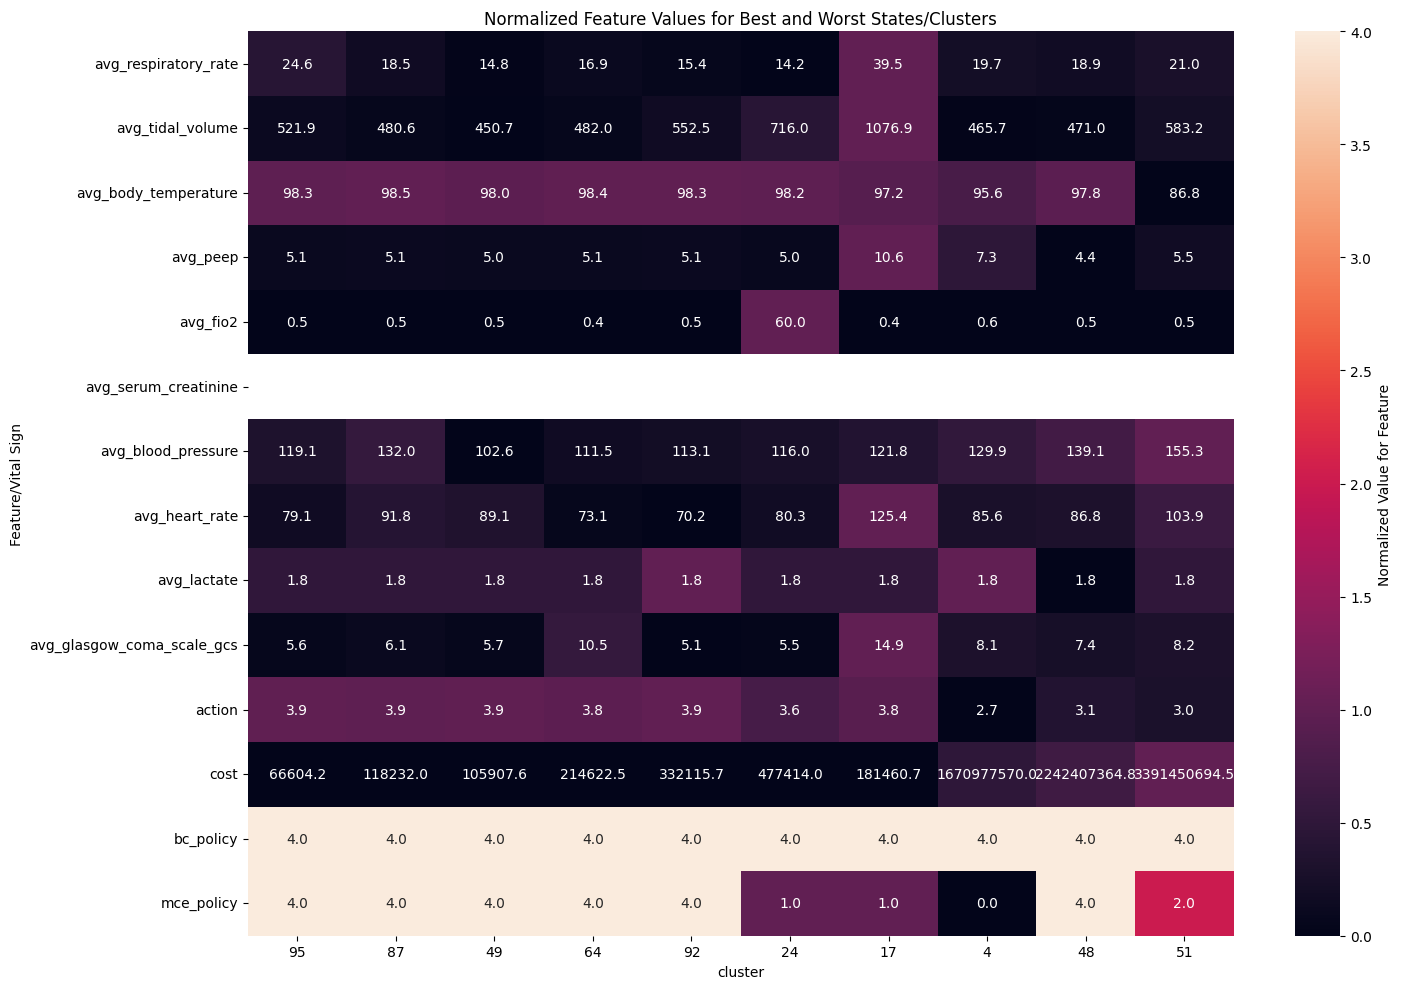

In [ ]:
import seaborn as sns

highest_five_states = np.argsort(reward_maxent_causal)[-5:]

lowest_five_states = np.argsort(reward_maxent_causal)[:5]
selected_states = np.concatenate((lowest_five_states, highest_five_states))
selected_states = selected_states[::-1]
print(reward_maxent_causal[selected_states])
find_cluster_means = data_non_normalized_df.groupby('cluster').mean()
selected_clusters = find_cluster_means.loc[selected_states]

normalized_selected_clusters = (selected_clusters - selected_clusters.min())/ (selected_clusters.max() - selected_clusters.min())
normalized_selected_clusters['bc_policy'] = bc_policy[selected_states]
normalized_selected_clusters['mce_policy'] = policy_mce[selected_states]
selected_clusters['bc_policy'] = bc_policy[selected_states]
selected_clusters['mce_policy'] = policy_mce[selected_states]

plt.figure(figsize=(15, 10))
sns.heatmap(normalized_selected_clusters.T, cbar_kws={'label' : 'Normalized Value for Feature'}, annot=selected_clusters.T, fmt='.1f')
plt.title('Normalized Feature Values for Best and Worst States/Clusters')
plt.ylabel('Feature/Vital Sign')
plt.tight_layout()
plt.savefig('NormalizedFeatures-smoothp25.png')
plt.show()

In [ ]:
policy_mce

array([1, 4, 4, 4, 3, 4, 0, 0, 1, 3, 3, 1, 1, 1, 4, 1, 3, 3, 1, 1, 1, 1,
       1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 4, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 4, 1, 1, 1, 0])

<ipython-input-176-173a3ace8881>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + list(range(1, 11)))
<ipython-input-176-173a3ace8881>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + list(range(1, 11)))


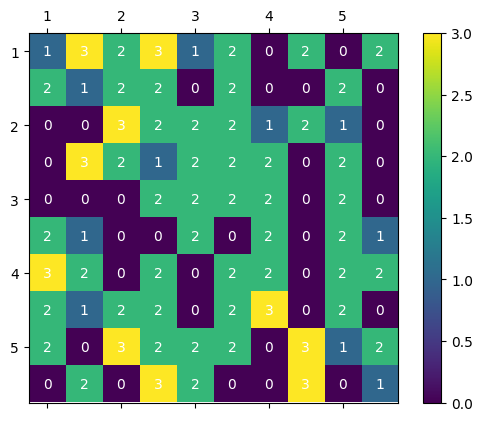

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Given array
data = np.array([1, 3, 2, 3, 1, 2, 0, 2, 0, 2, 2, 1, 2, 2, 0, 2, 0, 0, 2, 0,
                 0, 0, 3, 2, 2, 2, 1, 2, 1, 0, 0, 3, 2, 1, 2, 2, 2, 0, 2, 0,
                 0, 0, 0, 2, 2, 2, 2, 0, 2, 0, 2, 1, 0, 0, 2, 0, 2, 0, 2, 1,
                 3, 2, 0, 2, 0, 2, 2, 0, 2, 2, 2, 1, 2, 2, 0, 2, 3, 0, 2, 0,
                 2, 0, 3, 2, 2, 2, 0, 3, 1, 2, 0, 2, 0, 3, 2, 0, 0, 3, 0, 1])

# Reshape the array into a 10x10 matrix
matrix = data.reshape((10, 10))

# Create a figure and a set of subplots
fig, ax = plt.subplots()

# Use matshow to display the matrix
cax = ax.matshow(matrix, cmap='viridis')

# Add colorbar for reference
fig.colorbar(cax)

# Loop over data dimensions and create text annotations.
for i in range(10):
    for j in range(10):
        text = ax.text(j, i, matrix[i, j],
                       ha="center", va="center", color="w")

# Set tick labels for the grid
ax.set_xticklabels([''] + list(range(1, 11)))
ax.set_yticklabels([''] + list(range(1, 11)))

plt.show()


In [ ]:
policy_mce == data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def compare_policies(policy1, policy2):
    # Normalize the policies
    policy1 /= policy1.sum(axis=1, keepdims=True)
    policy2 /= policy2.sum(axis=1, keepdims=True)

    # Function to calculate entropy of probability distributions
    def calculate_entropy(policy):
        return -np.sum(policy * np.log(policy + 1e-9), axis=1)

    # Calculate entropy for both policies
    entropy1 = calculate_entropy(policy1)
    entropy2 = calculate_entropy(policy2)

    # Calculate preference-based differences
    preference_diff = np.abs(policy1 - policy2)
    overall_diff = np.sum(preference_diff)/policy1.shape[0]
    avg_statewise_diff = np.mean(np.sum(preference_diff, axis=1))
    avg_actionwise_diff = np.mean(preference_diff, axis=0)

    # Compare policies for ability-based differences
    most_probable_action1 = np.argmax(policy1, axis=1)
    most_probable_action2 = np.argmax(policy2, axis=1)
    ability_diff_count = np.sum(most_probable_action1 != most_probable_action2)/policy1.shape[0]

    # Set plot style
    sns.set_style("whitegrid")

    # Plotting entropy of both policies
    plt.figure(figsize=(12, 6), dpi=120)
    plt.plot(entropy1, label='Policy 1 Entropy', color='blue')
    plt.plot(entropy2, label='Policy 2 Entropy', color='red')
    plt.title('Entropy of Policies')
    plt.xlabel('State')
    plt.ylabel('Entropy')
    plt.legend()
    plt.show()

    # Plotting the average action-wise difference
    plt.figure(figsize=(8, 4))
    sns.barplot(x=np.arange(4), y=avg_actionwise_diff, palette='viridis')
    plt.title('Average Action-wise Preference Difference')
    plt.xlabel('Action')
    plt.ylabel('Average Difference in Probability')
    plt.show()

    # Plotting differences in most probable actions
    plt.figure(figsize=(12, 6), dpi=120)
    plt.plot(most_probable_action1, label='Policy 1 Most Probable Action', color='green')
    plt.plot(most_probable_action2, label='Policy 2 Most Probable Action', color='orange')
    plt.title('Most Probable Actions of Policies')
    plt.xlabel('State')
    plt.ylabel('Most Probable Action')
    plt.legend()
    plt.show()

    # Print the results
    print("Overall Preference Difference:", overall_diff)
    print("Average State-wise Preference Difference:", avg_statewise_diff)
    print("Ability-based Difference Count:", ability_diff_count)



In [ ]:
k_mean_100_base_policy = np.array([[0.25915716, 0.09616153, 0.42627804, 0.21840327],
[0.23267453, 0.18581447, 0.32974777, 0.25176322],
[0.2048565 , 0.25981003, 0.17993809, 0.35539537],
[0.46562245, 0.30461175, 0.10967118, 0.12009461],
[0.11813898, 0.0619814 , 0.49935001, 0.32052961],
[0.37660329, 0.52323665, 0.02617474, 0.07398532],
[0.57367943, 0.17448047, 0.10310351, 0.14873659],
[0.11439677, 0.11933313, 0.44840874, 0.31786135],
[0.05717088, 0.2205141 , 0.39166958, 0.33064543],
[0.09431144, 0.04897025, 0.64860529, 0.20811303],
[0.64053625, 0.29284316, 0.02689954, 0.03972106],
[0.23027129, 0.05574018, 0.49511213, 0.2188764 ],
[0.35996658, 0.29743227, 0.1230119 , 0.21958924],
[0.04408678, 0.0362375 , 0.51841735, 0.40125837],
[0.20433667, 0.20124478, 0.36142002, 0.23299853],
[0.07172022, 0.03607155, 0.67233318, 0.21987505],
[0.31340397, 0.22451299, 0.27107324, 0.19100979],
[0.1715711 , 0.13226192, 0.33945364, 0.35671334],
[0.08804066, 0.07328849, 0.50671364, 0.33195722],
[0.35376188, 0.520316  , 0.02213917, 0.10378295],
[0.54081423, 0.30458265, 0.03988082, 0.1147223 ],
[0.23832995, 0.13450762, 0.31011421, 0.31704822],
[0.32403643, 0.40536801, 0.04534258, 0.22525298],
[0.38978225, 0.09852532, 0.3471304 , 0.16456204],
[0.43624907, 0.49157219, 0.04176657, 0.03041217],
[0.164042  , 0.04568164, 0.44429255, 0.34598382],
[0.08496857, 0.06211449, 0.51338122, 0.33953573],
[0.52349418, 0.37463245, 0.02761374, 0.07425962],
[0.45356185, 0.42967727, 0.04372393, 0.07303696],
[0.41123332, 0.36595818, 0.04235928, 0.18044921],
[0.66010162, 0.23335277, 0.03929823, 0.06724738],
[0.2466499 , 0.17257004, 0.26176522, 0.31901484],
[0.33905797, 0.25946182, 0.17259839, 0.22888182],
[0.51010418, 0.37364966, 0.0618512 , 0.05439496],
[0.26309494, 0.27552765, 0.20077789, 0.26059952],
[0.70764963, 0.1030831 , 0.10637999, 0.08288728],
[0.31822319, 0.36962841, 0.13765356, 0.17449483],
[0.52606029, 0.25705995, 0.10061836, 0.1162614 ],
[0.34524376, 0.44608069, 0.03474203, 0.17393352],
[0.10565627, 0.07246837, 0.48525299, 0.33662236],
[0.52040457, 0.17293992, 0.19239676, 0.11425875],
[0.46754426, 0.39859991, 0.04655683, 0.087299  ],
[0.10644938, 0.0525896 , 0.66608643, 0.17487459],
[0.18811152, 0.10120863, 0.42869012, 0.28198972],
[0.37022052, 0.34179178, 0.12678438, 0.16120333],
[0.10885794, 0.10892466, 0.45736436, 0.32485304],
[0.23486972, 0.12162079, 0.38827226, 0.25523724],
[0.44371878, 0.44433454, 0.04292811, 0.06901857],
[0.07447088, 0.03692868, 0.73402334, 0.1545771 ],
[0.12645591, 0.16244675, 0.35554867, 0.35554867],
[0.25122265, 0.25659953, 0.24608891, 0.24608891],
[0.1358123 , 0.0567727 , 0.64843909, 0.15897592],
[0.24184288, 0.14314008, 0.3733168 , 0.24170024],
[0.13653784, 0.13438503, 0.26210331, 0.46697382],
[0.36651879, 0.39669865, 0.08410715, 0.15267541],
[0.03976856, 0.06673835, 0.46437631, 0.42911677],
[0.08256984, 0.06375506, 0.43932356, 0.41435154],
[0.06387658, 0.15232008, 0.43881042, 0.34499292],
[0.29367185, 0.15032562, 0.40900693, 0.1469956 ],
[0.14536501, 0.11533553, 0.33118935, 0.40811011],
[0.37137205, 0.41263079, 0.07439842, 0.14159873],
[0.17478121, 0.0562701 , 0.57454665, 0.19440205],
[0.38902685, 0.38682531, 0.10433641, 0.11981143],
[0.34573942, 0.46983264, 0.02769167, 0.15673628],
[0.37991041, 0.08996449, 0.31673009, 0.213395  ],
[0.44066194, 0.46868701, 0.02018812, 0.07046293],
[0.65829404, 0.12057439, 0.12827723, 0.09285433],
[0.64719566, 0.25879188, 0.03684314, 0.05716933],
[0.10490992, 0.05046747, 0.54897107, 0.29565153],
[0.32621848, 0.19482516, 0.22098486, 0.2579715 ],
[0.38915168, 0.55105889, 0.01304146, 0.04674797],
[0.08496751, 0.06013096, 0.64731313, 0.2075884 ],
[0.09155237, 0.06303017, 0.48316555, 0.36225191],
[0.4588378 , 0.46934886, 0.02220011, 0.04961322],
[0.1495962 , 0.08483539, 0.52461049, 0.24095791],
[0.31208298, 0.10942021, 0.27458049, 0.30391633],
[0.42523692, 0.19471233, 0.23517989, 0.14487085],
[0.38777993, 0.43037316, 0.0465691 , 0.13527781],
[0.26375184, 0.25751952, 0.24512031, 0.23360833],
[0.09440995, 0.03516589, 0.72794595, 0.14247821],
[0.46682047, 0.42800294, 0.02814515, 0.07703144],
[0.37926324, 0.43669522, 0.07425526, 0.10978628],
[0.46288406, 0.20070275, 0.20060959, 0.1358036 ],
[0.24525752, 0.53286774, 0.10531905, 0.11655568],
[0.16845929, 0.11925929, 0.39673173, 0.31554969],
[0.62449853, 0.28003042, 0.04165663, 0.05381442],
[0.06347537, 0.05710756, 0.52762627, 0.3517908 ],
[0.44143065, 0.45324409, 0.02450306, 0.0808222 ],
[0.12550746, 0.08720199, 0.48887911, 0.29841144],
[0.46048152, 0.31663666, 0.06502648, 0.15785534],
[0.25443912, 0.23668263, 0.25443912, 0.25443912],
[0.31217035, 0.1192627 , 0.35462257, 0.21394437],
[0.08758253, 0.06184875, 0.56563708, 0.28493164],
[0.63124329, 0.24839251, 0.02880347, 0.09156072],
[0.54022816, 0.27954937, 0.07182883, 0.10839364],
[0.62317223, 0.1740008 , 0.09756668, 0.10526028],
[0.03688506, 0.02966746, 0.38478684, 0.54866065],
[0.08579744, 0.07753622, 0.26788504, 0.56878129],
[0.25748142, 0.3618931 , 0.0531338 , 0.32749167],
[0.38779489, 0.46003545, 0.02350654, 0.12866311]])

In [ ]:
kmean_100_costincluded_policy = np.array([[2.89257544e-01, 6.34784624e-01, 6.30285639e-03, 6.96549761e-02],
       [2.20307903e-01, 1.93431757e-01, 2.85003361e-01, 3.01256979e-01],
       [1.14007305e-01, 4.78640545e-02, 5.35864580e-01, 3.02264060e-01],
       [4.25042504e-02, 3.30543979e-02, 4.32067907e-01, 4.92373445e-01],
       [4.71649605e-01, 5.26653142e-01, 1.56403796e-04, 1.54084876e-03],
       [2.30287551e-01, 5.75682310e-02, 5.65904363e-01, 1.46239856e-01],
       [7.64227318e-01, 2.24712517e-01, 4.90842737e-03, 6.15173696e-03],
       [5.45964108e-02, 3.48967463e-02, 6.17322193e-01, 2.93184650e-01],
       [3.91531474e-01, 1.60584922e-01, 2.27756544e-01, 2.20127061e-01],
       [3.09961613e-02, 1.37628334e-02, 6.27400630e-01, 3.27840375e-01],
       [1.95620407e-01, 1.28271596e-01, 3.77391272e-01, 2.98716725e-01],
       [1.18179731e-01, 8.04456959e-01, 7.58906840e-03, 6.97742417e-02],
       [6.93972098e-02, 2.92854995e-02, 7.60693291e-01, 1.40624000e-01],
       [8.60964381e-02, 1.25067242e-01, 3.94418160e-01, 3.94418160e-01],
       [9.65548631e-01, 2.46499582e-02, 1.64135496e-03, 8.16005579e-03],
       [2.11363491e-02, 6.76685828e-03, 9.21747985e-01, 5.03488074e-02],
       [6.67806890e-01, 2.80412951e-01, 9.52510480e-03, 4.22550544e-02],
       [4.62502869e-01, 4.34268469e-01, 4.97891714e-02, 5.34394906e-02],
       [1.54621926e-01, 9.85047896e-02, 4.87287787e-01, 2.59585497e-01],
       [6.87367426e-01, 1.34570381e-01, 1.02170121e-01, 7.58920712e-02],
       [6.21112328e-01, 3.31354270e-01, 4.31847989e-03, 4.32149215e-02],
       [7.48453849e-01, 1.71742764e-01, 2.76941915e-02, 5.21091953e-02],
       [7.62038206e-03, 5.95388271e-03, 3.64511428e-01, 6.21914308e-01],
       [3.79042618e-02, 1.09178576e-02, 8.59294232e-01, 9.18836483e-02],
       [1.17886085e-01, 3.85386694e-02, 4.32280504e-01, 4.11294742e-01],
       [2.53299081e-01, 1.31074202e-01, 3.89189526e-01, 2.26437191e-01],
       [4.68441527e-01, 4.78458336e-01, 3.18862500e-03, 4.99115117e-02],
       [1.48512241e-01, 5.51063290e-02, 5.30691101e-01, 2.65690329e-01],
       [2.94897784e-01, 3.13763854e-01, 1.01661987e-01, 2.89676375e-01],
       [9.43942390e-01, 4.58164159e-02, 6.65456226e-03, 3.58663151e-03],
       [5.65257108e-01, 4.05455717e-01, 2.75530286e-04, 2.90116455e-02],
       [1.33517862e-01, 1.76694976e-01, 1.68102243e-01, 5.21684919e-01],
       [2.44409516e-02, 1.56841326e-02, 6.80209313e-01, 2.79665603e-01],
       [1.05650884e-01, 8.65729372e-01, 3.33633767e-04, 2.82861102e-02],
       [1.16911256e-02, 2.44146781e-02, 5.06722486e-01, 4.57171710e-01],
       [2.80783383e-02, 9.02210325e-03, 8.95551121e-01, 6.73484372e-02],
       [6.94225062e-02, 3.62363996e-02, 6.62172796e-01, 2.32168298e-01],
       [4.89520330e-01, 3.43628289e-01, 7.24531985e-02, 9.43981825e-02],
       [8.14957014e-02, 3.82597413e-02, 7.06874779e-01, 1.73369779e-01],
       [3.83350947e-01, 2.75631450e-01, 6.91452798e-02, 2.71872323e-01],
       [3.69269223e-01, 1.19079801e-01, 1.79003522e-01, 3.32647453e-01],
       [3.73043088e-01, 3.12022825e-01, 1.77493713e-01, 1.37440374e-01],
       [5.06474484e-01, 4.74503696e-01, 5.88589760e-04, 1.84332298e-02],
       [1.21638619e-01, 1.17706232e-01, 5.86921655e-01, 1.73733494e-01],
       [6.72141476e-02, 1.97959916e-02, 7.85105826e-01, 1.27884035e-01],
       [2.16702046e-01, 2.32851665e-02, 6.56228924e-01, 1.03783864e-01],
       [9.57973688e-02, 1.91382748e-02, 5.46650027e-01, 3.38414329e-01],
       [8.84911567e-01, 1.00732407e-01, 7.99747931e-04, 1.35562779e-02],
       [2.45763251e-01, 2.29349617e-01, 2.62443566e-01, 2.62443566e-01],
       [8.69387883e-01, 1.25784552e-01, 1.20302307e-03, 3.62454250e-03],
       [1.74789746e-02, 1.76620824e-02, 6.99846651e-01, 2.65012292e-01],
       [4.31638800e-01, 4.85637164e-01, 2.33762769e-03, 8.03864083e-02],
       [7.84234628e-01, 2.02094451e-01, 4.52165051e-03, 9.14927009e-03],
       [3.93306535e-01, 2.41244500e-01, 1.09149333e-01, 2.56299632e-01],
       [9.48634593e-03, 1.59896746e-02, 5.74424908e-01, 4.00099071e-01],
       [4.14106409e-01, 2.88637570e-01, 1.30155115e-01, 1.67100906e-01],
       [6.00027673e-02, 4.05831681e-02, 4.50147233e-01, 4.49266831e-01],
       [7.55311428e-01, 6.26559693e-02, 1.11588777e-01, 7.04438256e-02],
       [2.07541162e-02, 1.06336995e-02, 6.45067545e-01, 3.23544640e-01],
       [3.55968616e-01, 5.01845388e-01, 5.15912628e-02, 9.05947327e-02],
       [2.08409264e-02, 1.85233551e-02, 2.12695282e-01, 7.47940437e-01],
       [3.18215527e-02, 1.80943699e-02, 6.47290262e-01, 3.02793815e-01],
       [3.31339039e-01, 2.30148531e-01, 2.19256215e-01, 2.19256215e-01],
       [1.52761169e-02, 8.63145452e-03, 5.65969338e-01, 4.10123090e-01],
       [6.17716898e-01, 8.88861136e-02, 1.57617175e-01, 1.35779813e-01],
       [7.77544128e-02, 9.23296459e-02, 5.07598668e-01, 3.22317273e-01],
       [2.98106107e-02, 1.31575255e-02, 7.60207539e-01, 1.96824325e-01],
       [4.25191777e-01, 2.95149995e-01, 2.49168728e-02, 2.54741355e-01],
       [2.90393190e-02, 1.35545545e-02, 6.97635650e-01, 2.59770476e-01],
       [7.22636679e-02, 1.12179970e-02, 6.56671886e-01, 2.59846450e-01],
       [1.68728163e-01, 5.36795318e-02, 6.06280293e-01, 1.71312013e-01],
       [4.49387816e-01, 4.74552521e-01, 3.06129537e-02, 4.54467093e-02],
       [1.35149816e-01, 6.75716041e-02, 5.28476455e-01, 2.68802124e-01],
       [5.58240496e-02, 3.90056912e-02, 6.70549633e-01, 2.34620627e-01],
       [4.95470972e-01, 4.86636964e-01, 1.37189033e-04, 1.77548752e-02],
       [2.55768983e-02, 1.82391606e-01, 4.47001241e-01, 3.45030255e-01],
       [4.69103702e-02, 3.90799743e-02, 1.38682783e-01, 7.75326872e-01],
       [5.30474234e-01, 4.10209490e-01, 5.96804971e-03, 5.33482262e-02],
       [2.45176176e-02, 1.41819528e-01, 4.81735646e-01, 3.51927208e-01],
       [8.60731031e-01, 1.35252987e-01, 6.87686476e-04, 3.32829627e-03],
       [3.53051950e-02, 2.63218197e-02, 5.14077116e-01, 4.24295869e-01],
       [4.73432761e-01, 3.74403555e-01, 3.17357831e-02, 1.20427901e-01],
       [3.12343734e-02, 3.27149742e-02, 4.54415212e-01, 4.81635441e-01],
       [8.46405284e-02, 2.25989225e-02, 7.35878833e-01, 1.56881716e-01],
       [2.03913238e-01, 8.73063075e-02, 3.89093562e-01, 3.19686892e-01],
       [6.71612939e-02, 4.33209828e-02, 5.06475752e-01, 3.83041972e-01],
       [3.97126791e-01, 3.59797957e-02, 3.81293043e-01, 1.85600371e-01],
       [2.74847277e-01, 1.76518582e-01, 1.98391228e-01, 3.50242913e-01],
       [4.24917690e-01, 5.57203480e-01, 3.31188164e-03, 1.45669484e-02],
       [1.21626194e-01, 9.47657848e-02, 5.35883752e-01, 2.47724269e-01],
       [6.85051885e-01, 2.95882109e-01, 1.76006878e-03, 1.73059371e-02],
       [5.73814402e-02, 1.87480415e-02, 6.10596056e-01, 3.13274462e-01],
       [4.16506271e-01, 1.94972084e-01, 1.79146232e-01, 2.09375413e-01],
       [1.57364926e-01, 2.33970077e-01, 1.74251563e-01, 4.34413434e-01],
       [1.93744140e-02, 8.08625549e-03, 9.04510277e-01, 6.80290539e-02],
       [6.42667235e-01, 2.08148095e-01, 7.24101888e-02, 7.67744812e-02],
       [4.97339466e-01, 3.44563487e-01, 9.51991458e-02, 6.28979011e-02],
       [3.39503256e-01, 3.05759850e-01, 1.18423807e-02, 3.42894514e-01],
       [6.97896148e-01, 2.50780493e-01, 1.45422130e-02, 3.67811458e-02],
       [2.72835012e-01, 3.41809456e-01, 6.59235361e-02, 3.19431996e-01]])

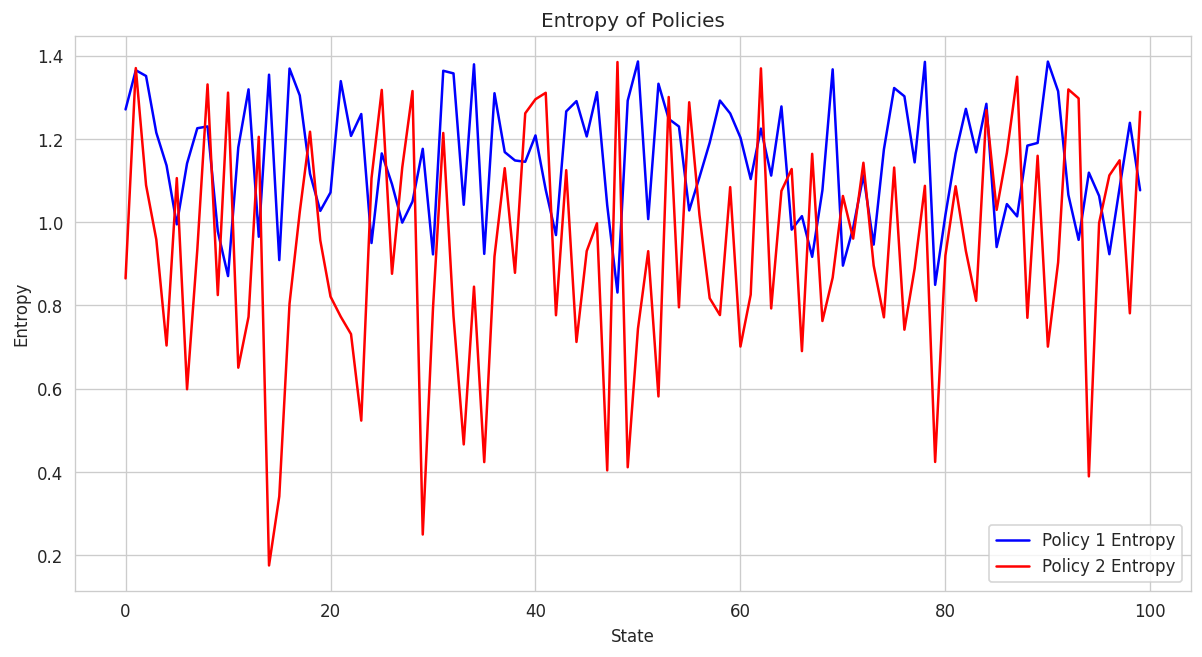

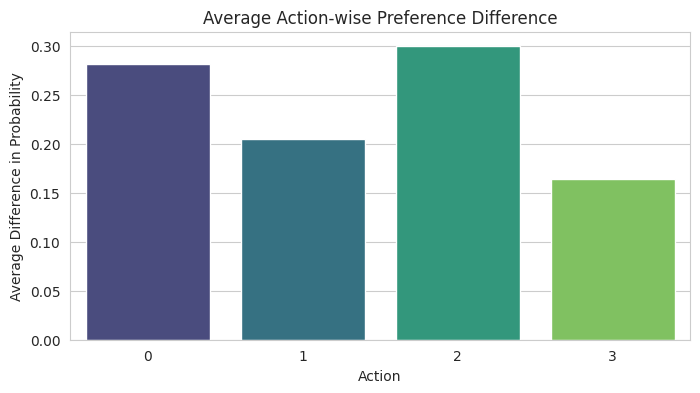

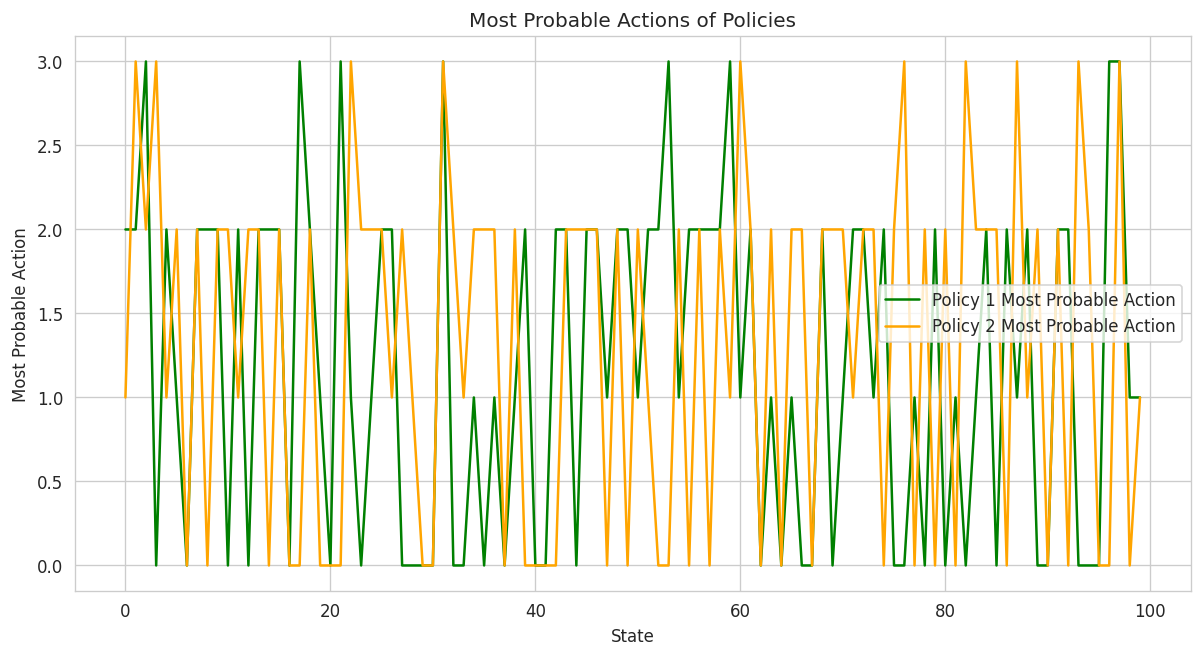

Overall Preference Difference: 0.949398858978952
Average State-wise Preference Difference: 0.9493988589789519
Ability-based Difference Count: 0.67


In [ ]:
compare_policies(k_mean_100_base_policy, kmean_100_costincluded_policy)